In [44]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np

pd.set_option('display.max_columns', None)

data = tf.data.TextLineDataset("../data/phishing.txt")

word_vectorizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>', document_count=5, split='\W')
word_vectorizer.fit_on_texts(str(x) for x in data.as_numpy_iterator())
LW = len(word_vectorizer.word_counts)
LW

23790

In [53]:
def postpad_to(sequence, ):
    return tf.keras.preprocessing.sequence.pad_sequences(sequence, 200, padding='post', truncating='post')

def mix_and_match():
    for txt in map(str, data.as_numpy_iterator()):
        wv = tf.reshape(postpad_to(word_vectorizer.texts_to_sequences([txt])), [-1])
        yield wv, tf.constant([0, 1])

ds = tf.data.Dataset.from_generator(
    mix_and_match,
    output_types=(tf.float64, tf.float64),
    output_shapes=(tf.TensorShape([200]), tf.TensorShape([2])),
).batch(256)

ds.element_spec

(TensorSpec(shape=(None, 200), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word (InputLayer)            [(None, 200)]             0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 200, 32)           761280    
_________________________________________________________________
dense_comb_1 (Dense)         (None, 200, 16)           528       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_comb_end (Dense)       (None, 2)                 6402      
Total params: 768,210
Trainable params: 768,210
Non-trainable params: 0
_________________________________________________________________


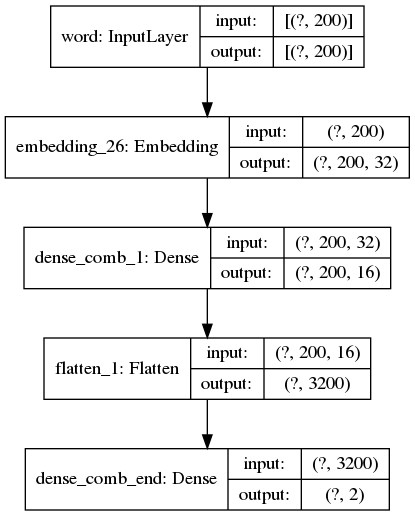

In [54]:
word_input = tf.keras.layers.Input(shape=(200,), name='word')

x = word_input
x = k.layers.Embedding(LW, 32, mask_zero=True)(x)
x = k.layers.Dense(16, activation='relu', name='dense_comb_1')(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(2, activation='softmax', name='dense_comb_end')(x)

model = k.models.Model(inputs=[word_input], outputs=[x])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [55]:
model.fit(ds, epochs=1)

     51/Unknown - 5s 106ms/step - loss: 0.1100 - accuracy: 0.9828

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[245,6] = 23790 is not in [0, 23790)
	 [[node model_23/embedding_26/embedding_lookup (defined at <ipython-input-55-a894466398cd>:1) ]]
	 [[model_23/embedding_26/embedding_lookup/_20]]
  (1) Invalid argument:  indices[245,6] = 23790 is not in [0, 23790)
	 [[node model_23/embedding_26/embedding_lookup (defined at <ipython-input-55-a894466398cd>:1) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_113036]

Errors may have originated from an input operation.
Input Source operations connected to node model_23/embedding_26/embedding_lookup:
 model_23/embedding_26/embedding_lookup/112702 (defined at /usr/lib/python3.6/contextlib.py:81)

Input Source operations connected to node model_23/embedding_26/embedding_lookup:
 model_23/embedding_26/embedding_lookup/112702 (defined at /usr/lib/python3.6/contextlib.py:81)

Function call stack:
distributed_function -> distributed_function


In [ ]:
for x in ds.take(1):
    print(x)
    break

